<a href="https://colab.research.google.com/github/Kalva014/HairHub/blob/main/colab_notebooks/Hair_Detection_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install transformers
!pip install torch
!pip install pandas

# Create Labeled Dataset

In [2]:
# Import libraries
import os
import glob
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [8]:
# Load the Input Images
inital_img_dir = '/content/drive/MyDrive/Hairhub_data/resized_imgs'
image_dataset = sorted(glob.glob(os.path.join(inital_img_dir, "*/*.jpg")))

/content/drive/MyDrive/Hairhub_data/resized_imgs/long_hairstyles/hairstyle0.jpg


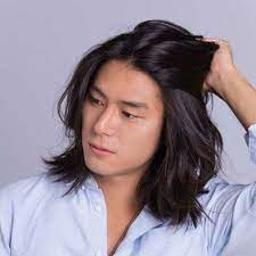

In [113]:
# Show the first image
print(image_dataset[0])
image = Image.open(image_dataset[0])
image

In [10]:
# Load the labels of the input images(aka the masks)
labels_dir = '/content/drive/MyDrive/Hairhub_data/masks'
labels_dataset = sorted(glob.glob(os.path.join(labels_dir, "*/*.csv")))

/content/drive/MyDrive/Hairhub_data/masks/long_hairstyles/hairstyle0.csv
(256, 256)


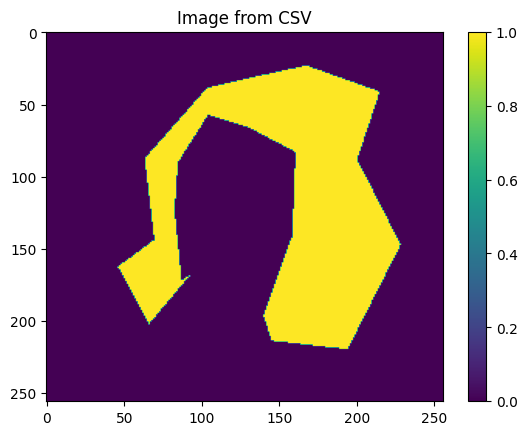

In [11]:
# Display the first mask
print(labels_dataset[0])

image_data = np.genfromtxt(labels_dataset[0], delimiter=' ')

print(image_data.shape)

plt.imshow(image_data, aspect='auto')
plt.title("Image from CSV")
plt.colorbar()
plt.show()

# Preprocess The Dataset

In [114]:
# Create two numpy arrays for the input
input_images, input_masks = [], []

num_images = len(image_dataset)
for i in range(num_images):
  image = Image.open(image_dataset[i])
  input_images.append(np.array(image))
  input_masks.append(np.genfromtxt(labels_dataset[i]))

In [115]:
# Convert the lists to numpy arrays so the model can use them
input_images = np.array(input_images)
input_masks = np.array(input_masks)

# Create The Model

In [116]:
# Run model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [117]:
class UNet(torch.nn.Module):
    def __init__(self, input_channels, num_classes):
        super(UNet, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes

        # Encoder
        self.conv1 = torch.nn.Conv2d(self.input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = torch.nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = torch.nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = torch.nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Middle
        self.conv9 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv10 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder
        self.up1 = torch.nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv11 = torch.nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        self.up2 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv13 = torch.nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.up3 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv15 = torch.nn.Conv2d(256, 128, kernel_size=3, padding=1)

        # Output
        self.out = torch.nn.Conv2d(128, self.num_classes, kernel_size=1)
        self.upsample = torch.nn.Upsample((256, 256), mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        x1 = torch.nn.functional.relu(self.conv1(x))
        x2 = torch.nn.functional.relu(self.conv2(x1))
        p1 = self.pool1(x2)

        x3 = torch.nn.functional.relu(self.conv3(p1))
        x4 = torch.nn.functional.relu(self.conv4(x3))
        p2 = self.pool2(x4)

        x5 = torch.nn.functional.relu(self.conv5(p2))
        x6 = torch.nn.functional.relu(self.conv6(x5))
        p3 = self.pool3(x6)

        x7 = torch.nn.functional.relu(self.conv7(p3))
        x8 = torch.nn.functional.relu(self.conv8(x7))
        p4 = self.pool4(x8)

        # Middle
        x9 = torch.nn.functional.relu(self.conv9(p4))
        x10 = torch.nn.functional.relu(self.conv10(x9))

        # Decoder
        x = self.up1(x10)
        x = torch.cat([x, x8], dim=1)
        x = torch.nn.functional.relu(self.conv11(x))

        x = self.up2(x)
        x = torch.cat([x, x6], dim=1)
        x = torch.nn.functional.relu(self.conv13(x))

        x = self.up3(x)
        x = torch.cat([x, x4], dim=1)
        x = torch.nn.functional.relu(self.conv15(x))

        # Output
        x = self.out(x)
        x = self.upsample(x)  # Upsample to match the original size

        return x


# Train The Model

In [118]:
# Initialize the model, loss function, and optimizer
unet_model = UNet(input_channels=3, num_classes=1) # Changed classes from 3 to 2
unet_model.to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001)

In [119]:
# Combine the two numpy arrays into a usable custom dataset with image-mask pairs
class ImageMaskDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert to PyTorch tensors
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()  # Assuming masks are integer values

        return {'image': image, 'mask': mask}

dataset = ImageMaskDataset(images=input_images, masks=input_masks)

In [120]:
# Save the dataset
torch.save(dataset, os.path.join('/content/drive/MyDrive/Hairhub_data', 'image_mask_dataset.pt'))

In [6]:
# Load the dataset
dataset = torch.load(os.path.join('/content/drive/MyDrive/Hairhub_data', 'image_mask_dataset.pt'))

AttributeError: ignored

In [121]:
# Initialize data loader to handle batching and shuffling
def worker_init_fn(worker_id):
    """
    This sets a different seed number for each worker so they generate
    different random numbers even if the initial seed is the same.
    """
    np.random.seed(seed=worker_id)

# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    worker_init_fn=worker_init_fn
)

In [122]:
# Training Loop
num_epochs = 50
criterion = torch.nn.BCEWithLogitsLoss() # might be wrong

for epoch in range(num_epochs):
  total_loss = 0.0

  for batch in data_loader:
        images, masks = batch['image'], batch['mask']

        # Put onto GPU to speed up
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        images = images.permute(0, 3, 1, 2) # (batch_size, input_channels, height, width)
        outputs = unet_model(images)

        # Calculate loss
        loss = criterion(outputs, masks[:, np.newaxis, :, :])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

  average_loss = total_loss / len(data_loader)
  print(f"Epoch: {epoch}, Loss: {average_loss}")

Epoch: 0, Loss: 0.8428745965162913
Epoch: 1, Loss: 0.4006587465604146
Epoch: 2, Loss: 0.30385735630989075
Epoch: 3, Loss: 0.2657878597577413
Epoch: 4, Loss: 0.5251004894574484
Epoch: 5, Loss: 0.34548333287239075
Epoch: 6, Loss: 0.32855112353960675
Epoch: 7, Loss: 0.28067288796106976
Epoch: 8, Loss: 0.22823495169480643
Epoch: 9, Loss: 0.2674854099750519
Epoch: 10, Loss: 0.2450313369433085
Epoch: 11, Loss: 0.23357776800791422
Epoch: 12, Loss: 0.30897363026936847
Epoch: 13, Loss: 0.16852393001317978
Epoch: 14, Loss: 0.2172547976175944
Epoch: 15, Loss: 0.21035946408907572
Epoch: 16, Loss: 0.1940990686416626
Epoch: 17, Loss: 0.26845857004324597
Epoch: 18, Loss: 0.18365561465422311
Epoch: 19, Loss: 0.21508015195528665
Epoch: 20, Loss: 0.17947388937075934
Epoch: 21, Loss: 0.21626584231853485
Epoch: 22, Loss: 0.1761560688416163
Epoch: 23, Loss: 0.184050515294075
Epoch: 24, Loss: 0.1716281125942866
Epoch: 25, Loss: 0.16842447221279144
Epoch: 26, Loss: 0.21173489590485892
Epoch: 27, Loss: 0.1716

# Save The Model

In [124]:
# Save the model's state dictionary to a file
torch.save({
    'model_state_dict': unet_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/content/drive/MyDrive/Hairhub_data/unet_model.pth')

# Load The Model

In [ ]:
# Load the entire model from the saved file
checkpoint = torch.load('/content/drive/MyDrive/Hairhub_data/unet_model.pth')

# Load the model state dictionary
unet_model.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state dictionary
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Evaluate the Model

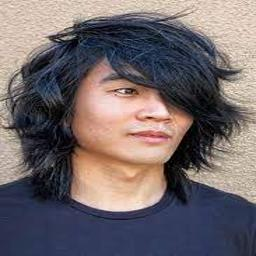

In [171]:
# Show the test image
image_array = dataset[2]['image'].numpy()
image = Image.fromarray(image_array.astype('uint8'), mode='RGB')
image

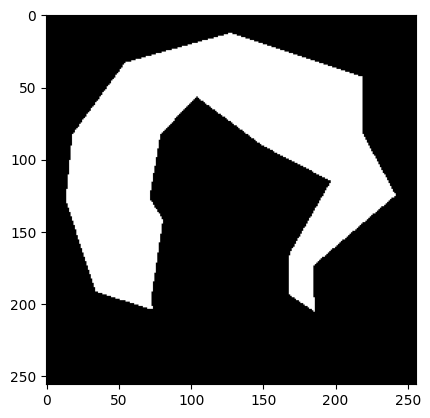

In [172]:
# Show the correct label of the image
mask_array = dataset[2]['mask'].numpy()
plt.imshow(mask_array.astype('uint8'), cmap='gray')
plt.show()

In [173]:
dataset[2]['image'][np.newaxis, :].shape

torch.Size([1, 256, 256, 3])

In [174]:
# Generate the predicted output from the model
x = dataset[2]['image'][np.newaxis, :].permute(0, 3, 1, 2).to(device)
y_hat = unet_model(x)

In [175]:
# Limit the values to get the pixels
threshold = -3
y_hat_hair = y_hat[0, 0] >= threshold
print(y_hat_hair.shape)

torch.Size([256, 256])


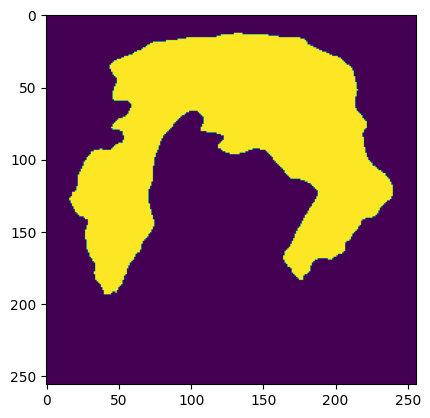

In [176]:
# Get the predictions for the 'hair' class
plt.imshow(y_hat_hair.cpu().detach().numpy())
plt.show()